# Load Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import math
from sklearn import preprocessing
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from operator import mul
from scipy.spatial import distance
import seaborn as sns
import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense,Multiply,Add, concatenate
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_recall_curve,roc_auc_score,precision_score

# Data Load

In [2]:
te = pd.read_csv('text_vectors.csv') # Doc2vec으로 뽑은 10차원의 Vector들
te.drop('Unnamed: 0',axis=1,inplace=True)

images = pd.read_csv('img_vecs.csv') # CNN으로 뽑은 10차원의 Vector들
images.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
label = pd.read_csv('label.csv')

Y= label['2_way_label']

In [4]:
data = pd.concat([te,images],axis=1)
data.reset_index(drop=True,inplace=True)


text = data.iloc[:,:100]
img = data.iloc[:,100:]

text.columns=range(0,100)
img .columns=range(0,100)

text['img=1']=0
img['img=1']=1

d_for_eda = pd.concat([text,img],axis=0)

# Original Distribution Visualize

In [5]:
x = d_for_eda.drop(['img=1'],axis=1)
y = d_for_eda['img=1']

x.reset_index(drop=True,inplace=True)

In [6]:
# PCA로 2차원으로 줄인 후, 시각화하는 함수 선언
def plot_3d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E','#00FFFF']
    markers = ['o', 's','d']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            X[y==l, 2],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [7]:
# PCA로 2차원으로 줄인 후, 시각화하는 함수 선언
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

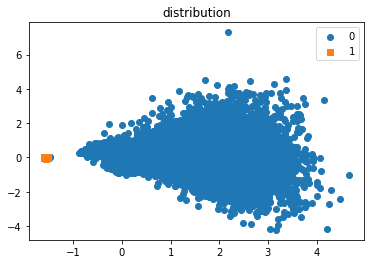

In [8]:
# 원본 데이터 분포
pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

# Vector Nomalize

In [9]:
d_for_eda.drop('img=1',axis=1,inplace=True)

norm_vec=[]
for i in tqdm(range(0,len(d_for_eda))):
    dot = d_for_eda.iloc[i:i+1,:].values
    norm = np.sqrt(np.dot(dot[0],dot[0]))
    scaled = (dot[0] / norm)
    norm_vec.append(scaled)

norm_vec = pd.DataFrame(np.array(norm_vec).reshape(len(data)*2,100))

100%|█████████████████████████████████████████████████████████████████████████| 32248/32248 [00:01<00:00, 24022.47it/s]


In [10]:
norm_vec.reset_index(drop=True,inplace=True)


text_norm = norm_vec.iloc[:len(te),:]
img_norm = norm_vec.iloc[len(te):,:]

text_norm.columns=range(0,100)
img_norm .columns=range(0,100)

# Nomalized Vector distribution Visualize

C:\Users\user\AppData\Local\Temp/ipykernel_17708/1158323884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_norm['img=1']=0
C:\Users\user\AppData\Local\Temp/ipykernel_17708/1158323884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_norm['img=1']=1


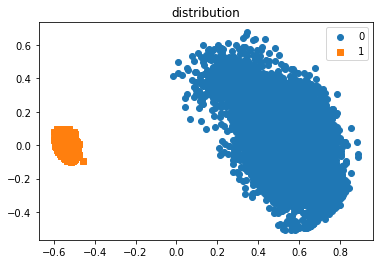

In [11]:
text_norm['img=1']=0
img_norm['img=1']=1
d_for_eda = pd.concat([text_norm,img_norm],axis=0)

x = d_for_eda.drop(['img=1'],axis=1)
y = d_for_eda['img=1']

x.reset_index(drop=True,inplace=True)

pca = PCA(n_components=2)
X = pca.fit_transform(x)
plot_2d_space(X, y, 'distribution')

# Original Data Statisitical Distribution

<AxesSubplot:ylabel='Density'>

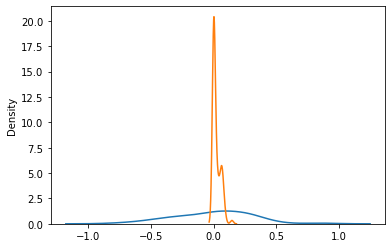

In [12]:
cv1 = te.mean()
cv2 = images.mean()

sns.kdeplot(cv1)
sns.kdeplot(cv2)

# Getting Weight and Implement Summation

In [13]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [14]:
def weighted_sum(text_vec,img_vec,text_norm,img_norm):
    # Getting Distance From Hyper Plane
    text_norm['img=1']=0
    img_norm['img=1']=1
    d_for_eda=pd.concat([text_norm,img_norm],axis=0)

    x = d_for_eda.drop('img=1',axis=1)
    y= d_for_eda['img=1']
    
    model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
    clf = model.fit(x, y)
    dis = clf.decision_function(x)
    
    dis = pd.DataFrame(dis,columns=['distance_ratio'])

    x.reset_index(drop=True,inplace=True)
    
    new = pd.concat([x,dis],axis=1)
    
    new['distance_ratio'] = abs(new['distance_ratio'])
    
    new.reset_index(drop=True,inplace=True)
    images.reset_index(drop=True,inplace=True)
    
    # Find a weight with a weight sum of 1

    new_te = new.iloc[:len(text_vec),:]
    new_img = new.iloc[len(text_vec):,:]
    new_img.reset_index(drop=True,inplace=True)
    
    div = new['distance_ratio'][:len(text_vec)].values+new['distance_ratio'][len(text_vec):].values    
    weisum = new_te['distance_ratio']*( new_te['distance_ratio'] / div)+new_img['distance_ratio']*( new_img['distance_ratio'] / div)

    img_norm.reset_index(drop=True,inplace=True)
    
    real_new=pd.concat([text_vec,img_vec],axis=1)
    real_new['con_dis'] = weisum

    x = real_new.drop(['con_dis'],axis=1)
    y = weisum
    
    inputs = Input(shape=(x.shape[1],))
    # MLP
    inputs = Input(shape=(x.shape[1],))
    Selection = Dense(x.shape[1], activation='sigmoid')(inputs)
    Selection = Model(inputs=inputs, outputs=Selection)
    Extraction = Dense(x.shape[1], activation='tanh')(inputs)
    Extraction = Model(inputs=inputs, outputs=Extraction)
    x_multiply = Multiply()([inputs,Selection.output])
    Added = Add()([x_multiply, Extraction.output])
    model = Model(inputs=inputs, outputs=Added)
    
    # 모델 컴파일
    model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['MSE'])
    
    # 모델 실행
    model.fit(x, y, epochs=100, batch_size=32)

    con_scalar=model.predict(x)
    con_scalar = pd.DataFrame(con_scalar)

    soft=[]
    for i in tqdm(range(0,len(con_scalar))):
        soft.append(softmax(con_scalar.iloc[i:i+1,:].values))
    new_one = pd.DataFrame(np.array(soft).reshape(len(con_scalar),200))
    
    text_scalar = new_one.iloc[:,:100]
    img_scalar = new_one.iloc[:,100:]
    
    # Multiply the weight by the distance again
    img_scalar.reset_index(drop=True,inplace=True)
    new.reset_index(drop=True,inplace=True)
    #for i in tqdm(range(0,len(text_vec))):
    #    text_scalar.iloc[i:i+1,:100] = text_scalar.iloc[i:i+1,:100]*(new_te['distance_ratio'][i])
    #    img_scalar.iloc[i:i+1,:100] = img_scalar.iloc[i:i+1,:100]*(new_img['distance_ratio'][i])
        
    # Weighted sum
    text_sum=text_vec*text_scalar.values
    img_sum= img_vec*img_scalar.values
    text_sum.reset_index(drop=True,inplace=True)
    img_sum.reset_index(drop=True,inplace=True)
    vectors=text_sum+img_sum
    return vectors

# Train Test Split

In [15]:
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)

In [16]:
x_te_train,x_te_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)
x_img_train,x_img_test,y_train,y_test= train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)

norm_te_train,norm_te_test,y_train,y_test = train_test_split(text_norm,y,test_size=0.3,random_state=2022,stratify=y)
norm_img_train,norm_img_test,y_train,y_test= train_test_split(img_norm,y,test_size=0.3,random_state=2022,stratify=y)

In [17]:
with tf.device("/device:CPU:0"):
    x_train = weighted_sum(x_te_train,x_img_train,norm_te_train,norm_img_train)
    x_test = weighted_sum(x_te_test,x_img_test,norm_te_test,norm_img_test)

Epoch 1/100
353/353 [==============================] - 0s 623us/step - loss: 0.2560 - MSE: 0.2560
Epoch 2/100
353/353 [==============================] - 0s 601us/step - loss: 0.0825 - MSE: 0.0825
Epoch 3/100
353/353 [==============================] - 0s 604us/step - loss: 0.0676 - MSE: 0.0676
Epoch 4/100
353/353 [==============================] - 0s 609us/step - loss: 0.0606 - MSE: 0.0606
Epoch 5/100
353/353 [==============================] - 0s 601us/step - loss: 0.0567 - MSE: 0.0567
Epoch 6/100
353/353 [==============================] - 0s 598us/step - loss: 0.0543 - MSE: 0.0543
Epoch 7/100
353/353 [==============================] - 0s 601us/step - loss: 0.0527 - MSE: 0.0527
Epoch 8/100
353/353 [==============================] - 0s 598us/step - loss: 0.0515 - MSE: 0.0515
Epoch 9/100
353/353 [==============================] - 0s 598us/step - loss: 0.0507 - MSE: 0.0507
Epoch 10/100
353/353 [==============================] - 0s 601us/step - loss: 0.0500 - MSE: 0.0500
Epoch 11/100
353/35

353/353 [==============================] - 0s 609us/step - loss: 0.0472 - MSE: 0.0472
Epoch 84/100
353/353 [==============================] - 0s 598us/step - loss: 0.0472 - MSE: 0.0472
Epoch 85/100
353/353 [==============================] - 0s 603us/step - loss: 0.0472 - MSE: 0.0472
Epoch 86/100
353/353 [==============================] - 0s 618us/step - loss: 0.0472 - MSE: 0.0472
Epoch 87/100
353/353 [==============================] - 0s 609us/step - loss: 0.0472 - MSE: 0.0472
Epoch 88/100
353/353 [==============================] - 0s 598us/step - loss: 0.0472 - MSE: 0.0472
Epoch 89/100
353/353 [==============================] - 0s 603us/step - loss: 0.0472 - MSE: 0.0472
Epoch 90/100
353/353 [==============================] - 0s 601us/step - loss: 0.0472 - MSE: 0.0472
Epoch 91/100
353/353 [==============================] - 0s 603us/step - loss: 0.0472 - MSE: 0.0472
Epoch 92/100
353/353 [==============================] - 0s 601us/step - loss: 0.0472 - MSE: 0.0472
Epoch 93/100
353/353 [=

100%|█████████████████████████████████████████████████████████████████████████| 11286/11286 [00:00<00:00, 18581.59it/s]


Epoch 1/100
152/152 [==============================] - 0s 588us/step - loss: 0.3785 - MSE: 0.3785
Epoch 2/100
152/152 [==============================] - 0s 588us/step - loss: 0.0943 - MSE: 0.0943
Epoch 3/100
152/152 [==============================] - 0s 581us/step - loss: 0.0699 - MSE: 0.0699
Epoch 4/100
152/152 [==============================] - 0s 601us/step - loss: 0.0590 - MSE: 0.0590
Epoch 5/100
152/152 [==============================] - 0s 581us/step - loss: 0.0525 - MSE: 0.0525
Epoch 6/100
152/152 [==============================] - 0s 588us/step - loss: 0.0481 - MSE: 0.0481
Epoch 7/100
152/152 [==============================] - 0s 588us/step - loss: 0.0449 - MSE: 0.0449
Epoch 8/100
152/152 [==============================] - 0s 601us/step - loss: 0.0425 - MSE: 0.0425
Epoch 9/100
152/152 [==============================] - 0s 588us/step - loss: 0.0406 - MSE: 0.0406
Epoch 10/100
152/152 [==============================] - 0s 588us/step - loss: 0.0391 - MSE: 0.0391
Epoch 11/100
152/15

152/152 [==============================] - 0s 601us/step - loss: 0.0301 - MSE: 0.0301
Epoch 84/100
152/152 [==============================] - 0s 594us/step - loss: 0.0301 - MSE: 0.0301
Epoch 85/100
152/152 [==============================] - 0s 594us/step - loss: 0.0301 - MSE: 0.0301
Epoch 86/100
152/152 [==============================] - 0s 608us/step - loss: 0.0301 - MSE: 0.0301
Epoch 87/100
152/152 [==============================] - 0s 601us/step - loss: 0.0301 - MSE: 0.0301
Epoch 88/100
152/152 [==============================] - 0s 601us/step - loss: 0.0301 - MSE: 0.0301
Epoch 89/100
152/152 [==============================] - 0s 601us/step - loss: 0.0301 - MSE: 0.0301
Epoch 90/100
152/152 [==============================] - 0s 594us/step - loss: 0.0301 - MSE: 0.0301
Epoch 91/100
152/152 [==============================] - 0s 601us/step - loss: 0.0301 - MSE: 0.0301
Epoch 92/100
152/152 [==============================] - 0s 608us/step - loss: 0.0301 - MSE: 0.0301
Epoch 93/100
152/152 [=

100%|███████████████████████████████████████████████████████████████████████████| 4838/4838 [00:00<00:00, 18657.38it/s]


# Visualization after combining

<AxesSubplot:ylabel='Density'>

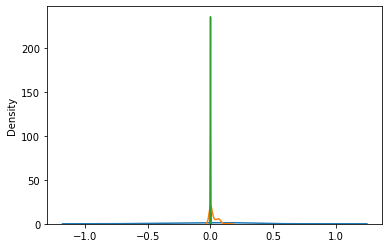

In [18]:
cv1 = te.mean()
cv2 = images.mean()
cv3 = x_train.mean()
sns.kdeplot(cv1)
sns.kdeplot(cv2)
sns.kdeplot(cv3)

In [19]:
te['img=1']=0
images['img=1']=1
x_train['img=1']=2

In [20]:
con = pd.concat([te,images,x_train],axis=0)
con.reset_index(drop=True,inplace=True)
x = con.drop(['img=1'],axis=1)
y = con['img=1'].values

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


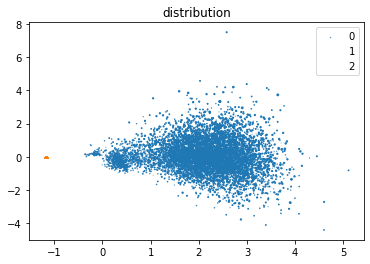

In [21]:
# 가중치 적용 후 분포 poly
pca = PCA(n_components=3)
X = pca.fit_transform(x)
plot_3d_space(X, y, 'distribution')

In [22]:
from sklearn.manifold import TSNE
# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components)
# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(x)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


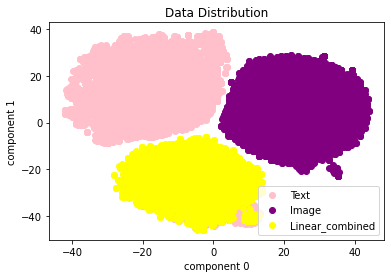

In [23]:
# class target 정보 불러오기 
tsne_df['target'] = con['img=1']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]

# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'Text')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'Image')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = 'Linear_combined')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.title('Data Distribution')
plt.legend()
plt.show()

In [24]:
te.drop(['img=1'],axis=1,inplace=True)

images.drop(['img=1'],axis=1,inplace=True)
x_train.drop(['img=1'],axis=1,inplace=True)

# Run!

In [25]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=100 , activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    
    # 결과 출력
    print("\n Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))

Epoch 1/50
353/353 [==============================] - 0s 603us/step - loss: 0.6515 - accuracy: 0.6180
Epoch 2/50
353/353 [==============================] - 0s 612us/step - loss: 0.5863 - accuracy: 0.6878
Epoch 3/50
353/353 [==============================] - 0s 612us/step - loss: 0.5613 - accuracy: 0.7093
Epoch 4/50
353/353 [==============================] - 0s 609us/step - loss: 0.5564 - accuracy: 0.7142
Epoch 5/50
353/353 [==============================] - 0s 606us/step - loss: 0.5532 - accuracy: 0.7166
Epoch 6/50
353/353 [==============================] - 0s 601us/step - loss: 0.5531 - accuracy: 0.7150
Epoch 7/50
353/353 [==============================] - 0s 601us/step - loss: 0.5524 - accuracy: 0.7168
Epoch 8/50
353/353 [==============================] - 0s 609us/step - loss: 0.5512 - accuracy: 0.7185
Epoch 9/50
353/353 [==============================] - 0s 632us/step - loss: 0.5502 - accuracy: 0.7182
Epoch 10/50
353/353 [==============================] - 0s 623us/step - loss: 0.549

In [26]:
with tf.device("/device:CPU:0"):
    y_pred = model.predict(x_test)
    
    predic =[]
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            predic.append(0)
        else:
            predic.append(1)

In [27]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.5771065182829889
0.7488631665977676
0.6419098143236075
0.7178992435535583
0.7231075697211156


# DNN based approach

In [30]:
label = pd.read_csv('label.csv')

Y= label['2_way_label']
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)

In [31]:
te_x_train,te_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)

img_x_train,img_test,y_train,y_test = train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)

#x_train = np.stack((te_x_train, img_x_train), axis=0)

In [32]:
with tf.device("/device:CPU:0"):
    
    # MLP
    inputs_te= Input(shape=(te_x_train.shape[1],))
    inputs_img= Input(shape=(img_x_train.shape[1],))
    
    text_layer = Dense(te_x_train.shape[1], activation='relu')(inputs_te)
    img_layer = Dense(img_x_train.shape[1], activation='relu')(inputs_img)
    concat = concatenate([text_layer, img_layer])
    #hidden1 = Dense(100, activation='relu')(concat)
    #hidden2 = Dense(100, activation='relu')(hidden1)
    out = Dense(1, activation='sigmoid')(concat)
    model = Model(inputs=[inputs_te,inputs_img], outputs=out)
    
    # 모델 컴파일
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit([te_x_train,img_x_train], y_train, epochs=50, batch_size=32)
    
    # 결과 출력
    #print("\n Accuracy: %.4f" % (model.evaluate((te_test.values,img_test.values), y_test)))

Epoch 1/50
353/353 [==============================] - 0s 569us/step - loss: 0.5933 - accuracy: 0.6941
Epoch 2/50
353/353 [==============================] - 0s 575us/step - loss: 0.5416 - accuracy: 0.7243
Epoch 3/50
353/353 [==============================] - 0s 575us/step - loss: 0.5192 - accuracy: 0.7447
Epoch 4/50
353/353 [==============================] - 0s 586us/step - loss: 0.4977 - accuracy: 0.7593
Epoch 5/50
353/353 [==============================] - 0s 575us/step - loss: 0.4741 - accuracy: 0.7771
Epoch 6/50
353/353 [==============================] - 0s 598us/step - loss: 0.4525 - accuracy: 0.7920
Epoch 7/50
353/353 [==============================] - 0s 578us/step - loss: 0.4342 - accuracy: 0.7998
Epoch 8/50
353/353 [==============================] - 0s 649us/step - loss: 0.4149 - accuracy: 0.8145
Epoch 9/50
353/353 [==============================] - 0s 586us/step - loss: 0.3963 - accuracy: 0.8245
Epoch 10/50
353/353 [==============================] - 0s 584us/step - loss: 0.385

In [33]:
with tf.device("/device:CPU:0"):
    predic =[]
    y_pred = model.predict((te_test.values,img_test.values))
    
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            predic.append(0)
        else:
            predic.append(1)

In [34]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.6020137784843668
0.7102108309218685
0.618399564507349
0.6907052965617361
0.6357022943480694


# Text only

In [37]:
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)
x_train,x_test,y_train,y_test = train_test_split(te,y,test_size=0.3,random_state=2022,stratify=y)

In [38]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=100 , activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
353/353 [==============================] - 0s 572us/step - loss: 0.5941 - accuracy: 0.7033
Epoch 2/50
353/353 [==============================] - 0s 572us/step - loss: 0.5142 - accuracy: 0.7520
Epoch 3/50
353/353 [==============================] - 0s 572us/step - loss: 0.4646 - accuracy: 0.7810
Epoch 4/50
353/353 [==============================] - 0s 612us/step - loss: 0.4294 - accuracy: 0.8053
Epoch 5/50
353/353 [==============================] - 0s 615us/step - loss: 0.3943 - accuracy: 0.8279
Epoch 6/50
353/353 [==============================] - 0s 569us/step - loss: 0.3619 - accuracy: 0.8440
Epoch 7/50
353/353 [==============================] - 0s 569us/step - loss: 0.3310 - accuracy: 0.8638
Epoch 8/50
353/353 [==============================] - 0s 569us/step - loss: 0.3058 - accuracy: 0.8777
Epoch 9/50
353/353 [==============================] - 0s 592us/step - loss: 0.2799 - accuracy: 0.8925
Epoch 10/50
353/353 [==============================] - 0s 618us/step - loss: 0.256

In [39]:
with tf.device("/device:CPU:0"):
    y_pred = model.predict(x_test)
    
    predic =[]
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            predic.append(0)
        else:
            predic.append(1)

In [40]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.5765765765765766
0.7091773460107482
0.6073123081216858
0.6852723614838152
0.6415094339622641


# Image only

In [42]:
le = preprocessing.LabelEncoder()
le.fit(Y.values) #Y변수 Label Encoding해주기

y = le.transform(Y.values)
x_train,x_test,y_train,y_test = train_test_split(images,y,test_size=0.3,random_state=2022,stratify=y)

In [43]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=100 , activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
353/353 [==============================] - 0s 581us/step - loss: 0.6694 - accuracy: 0.6099
Epoch 2/50
353/353 [==============================] - 0s 606us/step - loss: 0.6684 - accuracy: 0.6100
Epoch 3/50
353/353 [==============================] - 0s 586us/step - loss: 0.6668 - accuracy: 0.6100
Epoch 4/50
353/353 [==============================] - 0s 584us/step - loss: 0.6669 - accuracy: 0.6100
Epoch 5/50
353/353 [==============================] - 0s 589us/step - loss: 0.6658 - accuracy: 0.6100
Epoch 6/50
353/353 [==============================] - 0s 584us/step - loss: 0.6655 - accuracy: 0.6099
Epoch 7/50
353/353 [==============================] - 0s 612us/step - loss: 0.6648 - accuracy: 0.6101
Epoch 8/50
353/353 [==============================] - 0s 586us/step - loss: 0.6636 - accuracy: 0.6108
Epoch 9/50
353/353 [==============================] - 0s 589us/step - loss: 0.6633 - accuracy: 0.6108
Epoch 10/50
353/353 [==============================] - 0s 601us/step - loss: 0.662

In [44]:
with tf.device("/device:CPU:0"):
    y_pred = model.predict(x_test)
    
    predic =[]
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            predic.append(0)
        else:
            predic.append(1)

In [45]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.04080551139374669
0.6107895824720959
0.07560137457044674
0.5080340671167309
0.5133333333333333


# Concatanation Approach

In [46]:
train = pd.concat([te,images],axis=1)
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.3,random_state=2022,stratify=y)

In [47]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=200 , activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
353/353 [==============================] - 0s 615us/step - loss: 0.5765 - accuracy: 0.7071
Epoch 2/50
353/353 [==============================] - 0s 626us/step - loss: 0.5097 - accuracy: 0.7504
Epoch 3/50
353/353 [==============================] - 0s 629us/step - loss: 0.4715 - accuracy: 0.7759
Epoch 4/50
353/353 [==============================] - 0s 623us/step - loss: 0.4336 - accuracy: 0.8035
Epoch 5/50
353/353 [==============================] - 0s 635us/step - loss: 0.3998 - accuracy: 0.8259
Epoch 6/50
353/353 [==============================] - 0s 649us/step - loss: 0.3689 - accuracy: 0.8392
Epoch 7/50
353/353 [==============================] - 0s 629us/step - loss: 0.3398 - accuracy: 0.8595
Epoch 8/50
353/353 [==============================] - 0s 643us/step - loss: 0.3072 - accuracy: 0.8753
Epoch 9/50
353/353 [==============================] - 0s 637us/step - loss: 0.2800 - accuracy: 0.8901
Epoch 10/50
353/353 [==============================] - 0s 632us/step - loss: 0.255

In [48]:
with tf.device("/device:CPU:0"):
    y_pred = model.predict(x_test)
    
    predic =[]
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            predic.append(0)
        else:
            predic.append(1)

In [49]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.5914149443561209
0.7180653162463828
0.6206896551724138
0.6952330567256714
0.6530134581626682


# Element Wise Sum

In [50]:
train = te+images
x_train,x_test,y_train,y_test = train_test_split(train,y,test_size=0.3,random_state=2022,stratify=y)

In [51]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=100 , activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
353/353 [==============================] - 0s 584us/step - loss: 0.5899 - accuracy: 0.7002
Epoch 2/50
353/353 [==============================] - 0s 575us/step - loss: 0.5153 - accuracy: 0.7504
Epoch 3/50
353/353 [==============================] - 0s 584us/step - loss: 0.4688 - accuracy: 0.7798
Epoch 4/50
353/353 [==============================] - 0s 581us/step - loss: 0.4319 - accuracy: 0.8038
Epoch 5/50
353/353 [==============================] - 0s 595us/step - loss: 0.3985 - accuracy: 0.8238
Epoch 6/50
353/353 [==============================] - 0s 586us/step - loss: 0.3663 - accuracy: 0.8430
Epoch 7/50
353/353 [==============================] - 0s 606us/step - loss: 0.3382 - accuracy: 0.8593
Epoch 8/50
353/353 [==============================] - 0s 598us/step - loss: 0.3094 - accuracy: 0.8744
Epoch 9/50
353/353 [==============================] - 0s 584us/step - loss: 0.2837 - accuracy: 0.8880
Epoch 10/50
353/353 [==============================] - 0s 587us/step - loss: 0.262

In [52]:
with tf.device("/device:CPU:0"):
    y_pred = model.predict(x_test)
    
    predic =[]
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            predic.append(0)
        else:
            predic.append(1)

In [53]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.6263910969793323
0.7093840429929723
0.6270557029177719
0.694422251302272
0.6277217206585236


# Tensor Fusion Network

In [54]:
te['add1']=1
images['add1']=1

In [55]:
tfn=[]
for i in tqdm(range(0,len(te))):
    tfn.append(np.outer(te.iloc[i:i+1,:].values,images.iloc[i:i+1,:].values))

100%|██████████████████████████████████████████████████████████████████████████| 16124/16124 [00:03<00:00, 5365.80it/s]


In [56]:
tfn = np.array(tfn).reshape(16124,101*101)

x_train,x_test,y_train,y_test = train_test_split(tfn,y,test_size=0.3,random_state=2022,stratify=y)

In [57]:
with tf.device("/device:CPU:0"):
    # 모델의 설정
    model = Sequential()
    model.add(Dense(512,  input_dim=10201 , activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # 모델 컴파일
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    # 모델 실행
    model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
353/353 [==============================] - 9s 25ms/step - loss: 0.5768 - accuracy: 0.7125
Epoch 2/50
353/353 [==============================] - 8s 24ms/step - loss: 0.5037 - accuracy: 0.7593
Epoch 3/50
353/353 [==============================] - 8s 24ms/step - loss: 0.4488 - accuracy: 0.7927
Epoch 4/50
353/353 [==============================] - 8s 24ms/step - loss: 0.3917 - accuracy: 0.8284
Epoch 5/50
353/353 [==============================] - 8s 23ms/step - loss: 0.3259 - accuracy: 0.8623
Epoch 6/50
353/353 [==============================] - 8s 24ms/step - loss: 0.2676 - accuracy: 0.8943
Epoch 7/50
353/353 [==============================] - 8s 24ms/step - loss: 0.2187 - accuracy: 0.9195
Epoch 8/50
353/353 [==============================] - 8s 24ms/step - loss: 0.1731 - accuracy: 0.9399
Epoch 9/50
353/353 [==============================] - 8s 23ms/step - loss: 0.1413 - accuracy: 0.9522
Epoch 10/50
353/353 [==============================] - 8s 23ms/step - loss: 0.1175 - accura

In [58]:
with tf.device("/device:CPU:0"):
    y_pred = model.predict(x_test)
    
    predic =[]
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            predic.append(0)
        else:
            predic.append(1)

In [59]:
print(recall_score(y_test, predic))
print(accuracy_score(y_test,predic)) 
print(f1_score(y_test,predic))       
print(roc_auc_score(y_test,predic))
print(precision_score(y_test,predic))

0.6184419713831478
0.7137246796196776
0.6275880613068029
0.6965473157491815
0.6370087336244541
